In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData, alpha_HS04, check_fluxbalance
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters, show_footpoints, show_poles
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors, ticker
import matplotlib.pyplot as plt

from sunpy.net import Fido, attrs as a
import astropy.units as u
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SkyCoord
import sunpy.map
from matplotlib.patches import ConnectionPatch
from matplotlib import colors


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
folder = "/Users/lilli/Desktop/Thesis/SDO"

In [4]:
result = Fido.search(
    a.Time("2011/2/15 1:47:30", "2011/2/15 01:48:30"),
    a.Instrument.hmi,
    a.Physobs("LOS_magnetic_field"),
    #a.Physobs("VECTOR_MAGNETIC_FIELD"),
)

files = Fido.fetch(result[:, 0], path="/Users/lilli/Desktop/mflex/data/{file}")

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.95s/file]


In [23]:
path = "/Users/lilli/sunpy/data/hmi_m_45s_2012_06_13_07_31_30_tai_magnetogram.fits"
#path = "/Users/lilli/Desktop/mflex/data/hmi_m_45s_2011_02_15_01_48_45_tai_magnetogram.fits"
hmi_image = sunpy.map.Map(path).rotate()
hdr = hmi_image.fits_header

left_corner = SkyCoord(
    Tx=-450 * u.arcsec, Ty=-220 * u.arcsec, frame=hmi_image.coordinate_frame
)
right_corner = SkyCoord(
    Tx=-250 * u.arcsec, Ty=-100 * u.arcsec, frame=hmi_image.coordinate_frame
)

hpc_coords = sunpy.map.all_coordinates_from_map(hmi_image)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
magnetogram_big = sunpy.map.Map(hmi_image.data, hmi_image.meta, mask=mask)

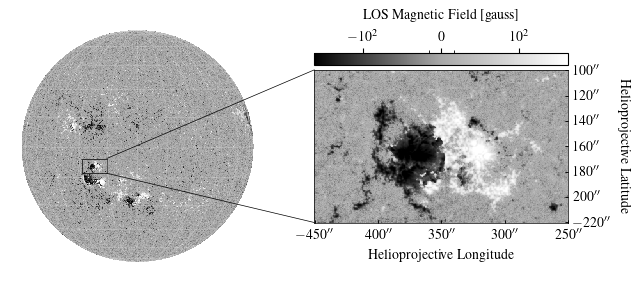

In [90]:
fig = plt.figure(figsize=(7.2, 4.8))
norm = colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax1 = fig.add_subplot(121, projection=magnetogram_big)
magnetogram_big.plot(
    axes=ax1,
    cmap=cmap,
    norm=norm,
    annotate=False,
)
magnetogram_big.draw_grid(axes=ax1, color="white", alpha=0.25, lw=0.5)
ax1.grid(alpha=0)
for coord in ax1.coords:
    coord.frame.set_linewidth(0)
    coord.set_ticks_visible(False)
    coord.set_ticklabel_visible(False)
    
magnetogram_big.draw_quadrangle(
    left_corner, top_right=right_corner, edgecolor="black", lw=0.5
)
magnetogram_small = hmi_image.submap(left_corner, top_right=right_corner)
ax2 = fig.add_subplot(122, projection=magnetogram_small)
im = magnetogram_small.plot(
    axes=ax2,
    norm=norm,
    cmap=cmap,
    annotate=False,
)
ax2.grid(alpha=0)
lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(0.5)
lat.frame.set_linewidth(0.5)
lon.set_axislabel(
    "Helioprojective Longitude",
)
lon.set_ticks_position("b")
lat.set_axislabel(
    "Helioprojective Latitude",
)
lat.set_axislabel_position("r")
lat.set_ticks_position("r")
lat.set_ticklabel_position("r")
xpix, ypix = magnetogram_big.wcs.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0, 1),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=0.5,
)
xpix, ypix = magnetogram_big.wcs.world_to_pixel(
    SkyCoord(right_corner.Tx, left_corner.Ty, frame=magnetogram_big.coordinate_frame)
)
con2 = ConnectionPatch(
    (0, 0),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=0.5,
)
ax2.add_artist(con1)
ax2.add_artist(con2)
ax2.tick_params(direction="in", length=2, width=0.5)

pos = ax2.get_position().get_points()
cax = fig.add_axes([pos[0, 0], pos[1, 1] + 0.01, pos[1, 0] - pos[0, 0], 0.025])
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.locator = ticker.FixedLocator([-1e2, 0, 1e2])
cbar.set_label("LOS Magnetic Field [gauss]", labelpad=-40, rotation=0)
cbar.update_ticks()
cbar.ax.xaxis.set_ticks_position("top")
plotname = folder + "/SDO_15022011.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [45]:
data2d = Field2dData.from_fits_SDO(path)

In [46]:
check_fluxbalance(data2d)

-0.1666931474306976

In [47]:
x_grid, y_grid = np.meshgrid(data2d.x, data2d.y)

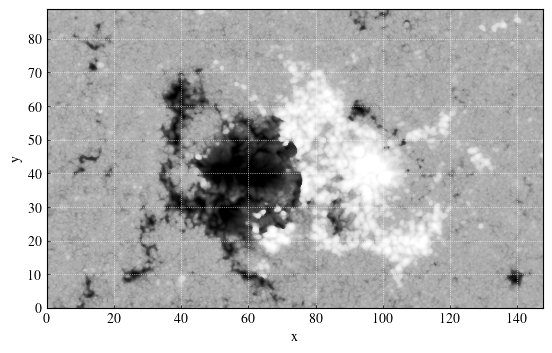

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(color="white", alpha=1.0, linestyle="dotted", linewidth=0.5)
ax.contourf(x_grid, y_grid, data2d.bz, 1000, cmap=cmap, norm = norm)
ax.set_box_aspect(data2d.y[-1]/data2d.x[-1])
ax.tick_params(direction="in", length=2, width=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
#plotname = folder + "/contour2.png"
#plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [49]:
print(data2d.bz.max())
print(data2d.bz.min())

1605.1401408614515
-1422.8482497570396


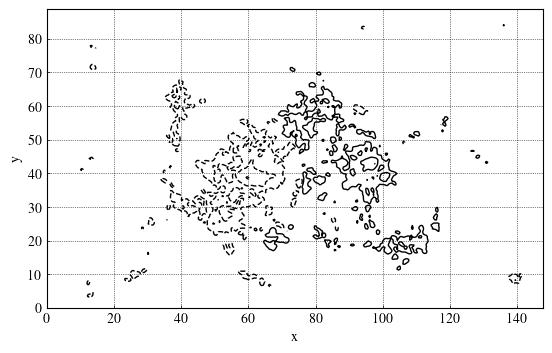

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-1400, -800, -200, 200, 900, 1600)),
    colors="k",
    linewidths=1.0,
)
ax.grid(color="black", alpha=1.0, linestyle="dotted", linewidth=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.clabel(CS, fontsize=14, inline=True)
ax.set_box_aspect(data2d.y[-1]/data2d.x[-1])
ax.tick_params(direction="in", length=2, width=0.5)
#plotname = folder + "/contour.png"
#plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

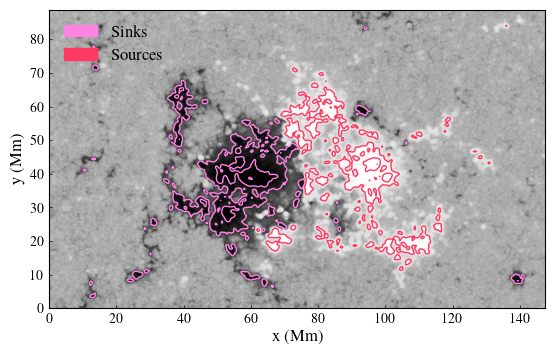

In [91]:
import matplotlib.patches as mpatches

fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(
    x_grid,
    y_grid,
    data2d.bz,
    1000,
    cmap=cmap, 
    norm=norm,
)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-1400, -800, -200)),
    colors=(1.000, 0.514, 0.890),
    linewidths=1.0,
)
CS2 = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((200, 900, 1600)),
    colors=c4,
    linewidths=1.0,
)
ax.set_xlabel("x (Mm)", fontsize=12)
ax.set_ylabel("y (Mm)", fontsize=12)
#ax.clabel(CS, fontsize=14, inline=True)
#ax.clabel(CS2, fontsize=14, inline=True)
ax.set_box_aspect(data2d.ny/data2d.nx)
ax.tick_params(direction="in", length=2, width=0.5)
sinks_label = mpatches.Patch(color=(1.000, 0.514, 0.890), label="Sinks")
sources_label = mpatches.Patch(color=c4, label="Sources")
plt.legend(handles=[sinks_label, sources_label], frameon=False, fontsize=12, loc='upper left')
plotname =  folder + "/contourcombi.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [5]:
alpha = 0.01

length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * data2d.nx * data2d.px 
length_scale_y = 2.0 * data2d.ny * data2d.py 

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(data2d.nf) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(data2d.nf) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(data2d.nf) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())

NameError: name 'data2d' is not defined

In [ ]:
a = 0.3

In [ ]:
b = 1.0
z0 = 2.0
deltaz = 0.2

In [55]:
print(data2d.nx, data2d.ny, data2d.nz)

397 239 444


In [6]:
#data3d = calculate_magfield(data2d, a, b, alpha, z0, deltaz)
path = "/Users/lilli/Desktop/mflex/SDO/MHS/neu"
#data3d.save(path)

data3d = Field3dData.load(path)


In [ ]:
data3d = calculate_magfield(data2d, 0.0, b, alpha, z0, deltaz)
path = "/Users/lilli/Desktop/mflex/SDO/LFF"
data3d.save(path)

#data3d = Field3dData.load(path)

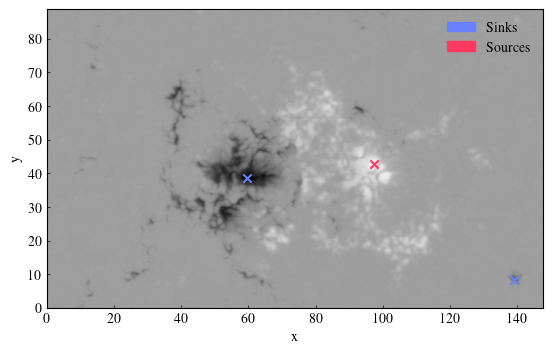

In [120]:
show_poles(data3d)

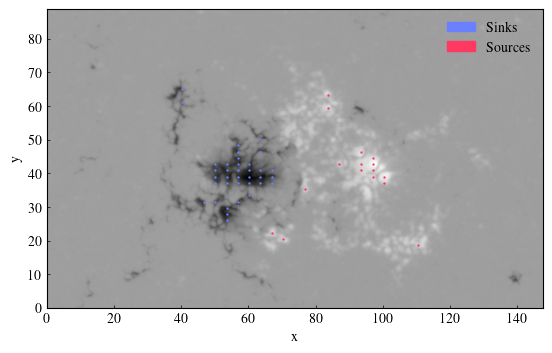

In [121]:
show_footpoints(data3d)

In [13]:
folder = "/Users/lilli/Desktop/ESPM"

#plot(data3d, 'los', False, True, path=folder)
#plot(data3d, 'side', False, True, path=folder)
#plot(data3d, 'angular', False, True, path=folder)

In [7]:
dpmhs_max = np.zeros_like(data3d.z)
dpmhs_min = np.zeros_like(data3d.z)

ddmhs_max = np.zeros_like(data3d.z)
ddmhs_min = np.zeros_like(data3d.z)

for iz in range(data3d.nz):
    dpmhs_max[iz] = data3d.dpressure[:, :, iz].max()
    dpmhs_min[iz] = data3d.dpressure[:, :, iz].min()
    ddmhs_max[iz] = data3d.ddensity[:, :, iz].max()
    ddmhs_min[iz] = data3d.ddensity[:, :, iz].min()

In [19]:
c4b =(1.000, 0.416, 0.937)
c10=(0.667, 1.000, 0.243)

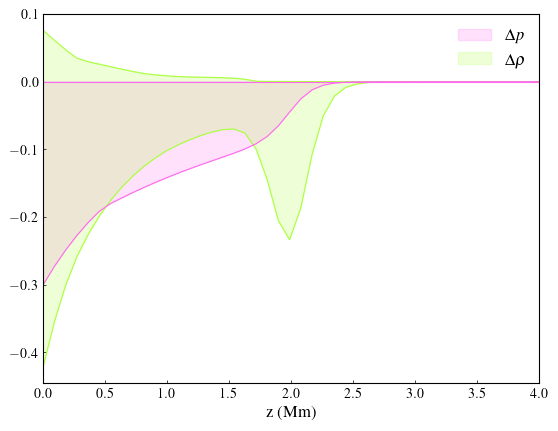

In [28]:
fig, ax1 = plt.subplots()

ax1.fill_between(data3d.z, dpmhs_min, dpmhs_max, color= c4b, alpha=0.2, label=r"$\Delta p$")
ax1.fill_between(data3d.z, ddmhs_min, ddmhs_max, color= c10, alpha=0.2, label=r"$\Delta \rho$")
ax1.plot(
    data3d.z,
    ddmhs_max,
    linewidth=0.8,
    color= c10,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data3d.z,
    ddmhs_min,
    linewidth=0.8,
    color= c10,
    # label=r"B-den, $p_0$ prescribed, linear",
)
ax1.plot(
    data3d.z,
    dpmhs_max,
    linewidth=0.8,
    color= c4b,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data3d.z,
    dpmhs_min,
    linewidth=0.8,
    color= c4b,
    # label=r"B-den, $p_0$ prescribed, linear",
)

#ax1.set_ylabel(r"$\Delta p$", fontsize=12)
ax1.set_xlabel(r"z (Mm)", fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tick_params(direction="in", length=2, width=0.5)
ax1.set_xlim(0, 4.0)
plotname = folder + "/pp_sdo.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

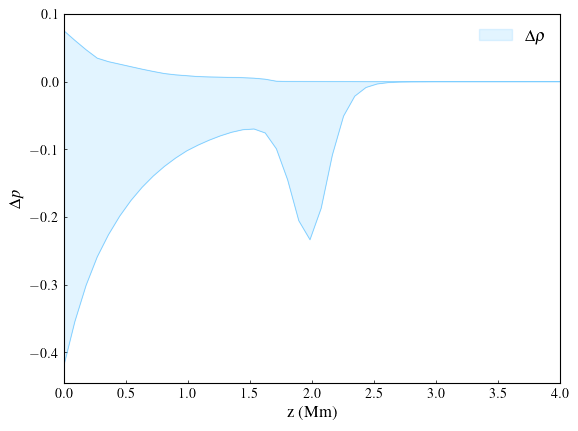

In [125]:
fig, ax1 = plt.subplots()

ax1.plot(
    data2d.z,
    ddmhs_max,
    linewidth=0.5,
    color= c1,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    ddmhs_min,
    linewidth=0.5,
    color= c1,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.fill_between(data2d.z, ddmhs_min, ddmhs_max, color= c1, alpha=0.2, label=r"$\Delta \rho$")

ax1.set_ylabel(r"$\Delta p$", fontsize=12)
ax1.set_xlabel(r"z (Mm)", fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tick_params(direction="in", length=2, width=0.5)
ax1.set_xlim(0, 4.0)
plotname = folder + "/dden.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()